# IBM Data Science Capstone Project


## Introduction and Background: 
In this project, we will try to find the similarities between the different cites in different continents. It will be helpful for the stakeholder who are looking to open a business or someone who is looking to move to a new cities.

We are using 12 cities: 4 from Australia, 4 from India, 5 from Europe. We will be using Foursquare and K-mean clustering to create cluster of the similar cities. If a person is acquitant with one of the cities, can have idea about the other members of that cluster. 

Overall, the following steps will be taken: 
1. Import the useful libraries for this project. 
2. Using Geopy library, we will extract the latitude and longitude of the cities. 
3. Using Foursquare API, we will explore the nearby venues arround the cities. 
4. Analyse the nearby venues of few cities using bar plot. 
5. Find the 15 most common venues of all the cities. 
6. Apply K-mean cluster algorithm to identify the clusters. 

## Data preparation steps
#### 1. Import the useful libraries for this project. 

In this section, we have imported several libraries and also changed the setting of pandas library to avoid '...' while displaying large number of columns. 

In [488]:
import pandas as pd
import numpy as np
import folium
import requests
from sklearn.cluster import KMeans

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors

# seting options for pandas
pd.set_option("max_colwidth", 200)
#pd.set_option("display.max_rows", 1000)
pd.set_option("display.max_columns", 9001)   # there is a scroll bar and '...' in columns display
pd.set_option("display.float_format", lambda x: '{:,.6f}'.format(x))

print('...Libraries imported')

...Libraries imported


#### 2. Using Geopy library, we will extract the latitude and longitude of the cities. 

The used cities for this analysis are from 3 continents -- 4 from Asia (in particular from India): Delhi, Mumbai, Bangalore, and Ahmedabad, 4 from Australia: Perth, Sydney, Brisbane, and Melbourne, 4 from Europe: Amsterdam, Rotterdam, Berlin, Munich, and Cologne. 



In [490]:
from  geopy.geocoders import Nominatim
geolocator = Nominatim(timeout=3)
city = ['Perth', 'Sydney', 'Melbourne', 'Brisbane', 'Amsterdam', 'Rotterdam', 'Berlin', 'Munich', 'Cologne', 'Delhi', 'Mumbai', 'Bangalore', 'Ahmedabad']
country = ['Australia', 'Australia','Australia', 'Australia' ,'The Netherlands', 'The Netherlands', 'Germany', 'Germany', 'Germany', 'India', 'India', 'India', 'India']
df_city = pd.DataFrame(columns = ['city','country','latitude','longitude'])
df_city['city'] = city
df_city['country'] = country

for i in df_city.index: 
    loc = geolocator.geocode(df_city['city'][i]+','+ df_city['country'][i])
    df_city['latitude'][i] = loc.latitude
    df_city['longitude'][i] = loc.longitude

df_city.drop(columns=['country'], inplace = True)
df_city

/Users/priyadwivedi/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: DeprecationWarning: Using Nominatim with the default "geopy/1.21.0" `user_agent` is strongly discouraged, as it violates Nominatim's ToS https://operations.osmfoundation.org/policies/nominatim/ and may possibly cause 403 and 429 HTTP errors. Please specify a custom `user_agent` with `Nominatim(user_agent="my-application")` or by overriding the default `user_agent`: `geopy.geocoders.options.default_user_agent = "my-application"`. In geopy 2.0 this will become an exception.
  


,city,latitude,longitude
0,Perth,-31.952712,115.860480
1,Sydney,-33.854816,151.216454
2,Melbourne,-37.814218,144.963161
3,Brisbane,-27.468968,153.023499
4,Amsterdam,52.372760,4.893604
5,Rotterdam,51.922896,4.463173
6,Berlin,52.517037,13.388860
7,Munich,48.137108,11.575382
8,Cologne,50.938361,6.959974
9,Delhi,28.651718,77.221939


To visualise these cities on the world map, we use follium library. 

In [491]:
adress = 'Australia'
loc = geolocator.geocode(adress)
latitude = loc.latitude
longitude = loc.longitude
map_world = folium.Map(location=[latitude, longitude], zoom_start = 2)

# add marker to the map
for lat, lng, city in zip(df_city['latitude'], df_city['longitude'], df_city['city']):
    label = '{}'.format(city)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_world)
    
map_world

#### 3. Using Foursquare API, we will explore the nearby venues arround the cities. 

We will be exploring the 100 venues per cities in a radius of 8 km. 

In [492]:
CLIENT_ID = '3MTNLOUO4MKYHQP5YGBM353DBBFGI4X5O1FWNUELWYVOXI0I' #  Foursquare ID
CLIENT_SECRET = 'WIDMUIGUAUCSEUWRNNRLEKNEETSRSHHDBLVTBNWL41MFPYRI' #  Foursquare Secret
VERSION = '20200520' # Foursquare API version

print('My credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

My credentails:
CLIENT_ID: 3MTNLOUO4MKYHQP5YGBM353DBBFGI4X5O1FWNUELWYVOXI0I
CLIENT_SECRET:WIDMUIGUAUCSEUWRNNRLEKNEETSRSHHDBLVTBNWL41MFPYRI


In [493]:
def find_nearby_venues(city, latitudes, longitudes, radius, LIMIT):
    venue_list = []
    for name, lat, lng in zip(city, latitudes, longitudes):
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)

        results = requests.get(url).json()["response"]['groups'][0]['items']
        for v in results:
            venue_list.append([name, lat, lng, v['venue']['name'], v['venue']['location']['lat'], v['venue']['location']['lng'], v['venue']['categories'][0]['name']])

    venue_list = pd.DataFrame(venue_list, columns = ['city', 'latitude', 'longitude', 'venue', 'lat', 'lng', 'category'])
    return(venue_list)

In [494]:
LIMIT = 100
radius = 8000
df_venue_list = find_nearby_venues(df_city['city'], df_city['latitude'], df_city['longitude'], radius, LIMIT)

df_venue_list.head()

,city,latitude,longitude,venue,lat,lng,category
0,Perth,-31.952712,115.860480,Toastface Grillah,-31.952441,115.860964,Sandwich Place
1,Perth,-31.952712,115.860480,Le Vietnam,-31.954256,115.860512,Vietnamese Restaurant
2,Perth,-31.952712,115.860480,Varnish on King,-31.950952,115.855536,Whisky Bar
3,Perth,-31.952712,115.860480,COMO The Treasury,-31.955622,115.860350,Hotel
4,Perth,-31.952712,115.860480,Alfred's Pizzeria & Smallbar,-31.954890,115.859901,Pizza Place


In [495]:
# Display the dataframe grouped by cities. 
df_venue_list.groupby('city').count()

,latitude,longitude,venue,lat,lng,category
city,,,,,,
Ahmedabad,100,100,100,100,100,100
Amsterdam,100,100,100,100,100,100
Bangalore,100,100,100,100,100,100
Berlin,100,100,100,100,100,100
Brisbane,100,100,100,100,100,100
Cologne,100,100,100,100,100,100
Delhi,100,100,100,100,100,100
Melbourne,100,100,100,100,100,100
Mumbai,100,100,100,100,100,100


In [496]:
# Convert the category column in dummy variables. 
df_with_dummies = pd.get_dummies(df_venue_list, prefix='', columns=['category'], prefix_sep="")
df_with_dummies.head()

,city,latitude,longitude,venue,lat,lng,Afghan Restaurant,African Restaurant,American Restaurant,Aquarium,Arcade,Argentinian Restaurant,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,Australian Restaurant,Austrian Restaurant,BBQ Joint,Bakery,Bar,Bavarian Restaurant,Beach,Beer Bar,Beer Garden,Beer Store,Bike Rental / Bike Share,Bistro,Bookstore,Botanical Garden,Bougatsa Shop,Boutique,Bowling Alley,Brazilian Restaurant,Breakfast Spot,Brewery,Bridge,Bubble Tea Shop,Burger Joint,Burrito Place,Butcher,Café,Canal,Candy Store,Capitol Building,Caribbean Restaurant,Caucasian Restaurant,Cheese Shop,Chinese Restaurant,Chocolate Shop,Church,Clothing Store,Club House,Cocktail Bar,Coffee Roaster,Coffee Shop,Comedy Club,Comic Shop,Concert Hall,Cosmetics Shop,Cricket Ground,Cupcake Shop,Deli / Bodega,Department Store,Dessert Shop,Diner,Dive Bar,Doner Restaurant,Donut Shop,Dutch Restaurant,Electronics Store,Empanada Restaurant,Event Space,Falafel Restaurant,Farmers Market,Fast Food Restaurant,Financial or Legal Service,Flea Market,Flower Shop,Food & Drink Shop,Food Court,Food Truck,Football Stadium,Fountain,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Furniture / Home Store,Gaming Cafe,Garden,Garden Center,Gastropub,General Entertainment,German Restaurant,Gift Shop,Golf Course,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Harbor / Marina,Historic Site,History Museum,Hostel,Hotel,Hotel Bar,IT Services,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Indie Theater,Indonesian Restaurant,Irani Cafe,Island,Italian Restaurant,Japanese Restaurant,Jazz Club,Juice Bar,Karaoke Bar,Karnataka Restaurant,Kebab Restaurant,Korean Restaurant,Latin American Restaurant,Lebanese Restaurant,Library,Liquor Store,Lounge,Manti Place,Market,Mediterranean Restaurant,Men's Store,Mexican Restaurant,Meze Restaurant,Middle Eastern Restaurant,Mini Golf,Miscellaneous Shop,Modern European Restaurant,Molecular Gastronomy Restaurant,Monument / Landmark,Movie Theater,Multiplex,Museum,Music Venue,New American Restaurant,Night Market,Nightclub,Noodle House,North Indian Restaurant,Northeast Indian Restaurant,Opera House,Organic Grocery,Other Great Outdoors,Outdoor Sculpture,Outdoor Supply Store,Pakistani Restaurant,Paper / Office Supplies Store,Park,Parsi Restaurant,Pastry Shop,Pedestrian Plaza,Performing Arts Venue,Pizza Place,Playground,Plaza,Pool,Pub,Racetrack,Record Shop,Recreation Center,Rental Car Location,Residential Building (Apartment / Condo),Restaurant,River,Salad Place,Salon / Barbershop,Sandwich Place,Scandinavian Restaurant,Scenic Lookout,Schnitzel Restaurant,Science Museum,Sculpture Garden,Seafood Restaurant,Shoe Store,Shopping Mall,Shopping Plaza,Smoke Shop,Snack Place,South Indian Restaurant,Spa,Spanish Restaurant,Speakeasy,Spiritual Center,Sporting Goods Shop,Stadium,Steakhouse,Storage Facility,Street Art,Supermarket,Surf Spot,Sushi Restaurant,Tapas Restaurant,Tea Room,Tennis Stadium,Thai Restaurant,Theater,Tibetan Restaurant,Tour Provider,Toy / Game Store,Track,Trail,Train Station,Trattoria/Osteria,Vacation Rental,Vegetarian / Vegan Restaurant,Video Store,Vietnamese Restaurant,Volleyball Court,Waterfall,Waterfront,Whisky Bar,Wine Bar,Wine Shop,Yoga Studio,Zoo,Zoo Exhibit
0,Perth,-31.952712,115.860480,Toastface Grillah,-31.952441,115.860964,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,Perth,-31.952712,115.860480,Le Vietnam,-31.954256,115.860512,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0

In [497]:
# Keep the city and dummy variables column. Drop the rest of the columns. 
df_with_dummies.drop(columns = ['latitude', 'longitude','venue', 'lat', 'lng'], inplace = True)

# Take the mean of the grouped dataset by cities. 
df_grouped = df_with_dummies.groupby(['city']).mean()
df_grouped.reset_index(inplace = True)

df_grouped

,city,Afghan Restaurant,African Restaurant,American Restaurant,Aquarium,Arcade,Argentinian Restaurant,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,Australian Restaurant,Austrian Restaurant,BBQ Joint,Bakery,Bar,Bavarian Restaurant,Beach,Beer Bar,Beer Garden,Beer Store,Bike Rental / Bike Share,Bistro,Bookstore,Botanical Garden,Bougatsa Shop,Boutique,Bowling Alley,Brazilian Restaurant,Breakfast Spot,Brewery,Bridge,Bubble Tea Shop,Burger Joint,Burrito Place,Butcher,Café,Canal,Candy Store,Capitol Building,Caribbean Restaurant,Caucasian Restaurant,Cheese Shop,Chinese Restaurant,Chocolate Shop,Church,Clothing Store,Club House,Cocktail Bar,Coffee Roaster,Coffee Shop,Comedy Club,Comic Shop,Concert Hall,Cosmetics Shop,Cricket Ground,Cupcake Shop,Deli / Bodega,Department Store,Dessert Shop,Diner,Dive Bar,Doner Restaurant,Donut Shop,Dutch Restaurant,Electronics Store,Empanada Restaurant,Event Space,Falafel Restaurant,Farmers Market,Fast Food Restaurant,Financial or Legal Service,Flea Market,Flower Shop,Food & Drink Shop,Food Court,Food Truck,Football Stadium,Fountain,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Furniture / Home Store,Gaming Cafe,Garden,Garden Center,Gastropub,General Entertainment,German Restaurant,Gift Shop,Golf Course,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Harbor / Marina,Historic Site,History Museum,Hostel,Hotel,Hotel Bar,IT Services,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Indie Theater,Indonesian Restaurant,Irani Cafe,Island,Italian Restaurant,Japanese Restaurant,Jazz Club,Juice Bar,Karaoke Bar,Karnataka Restaurant,Kebab Restaurant,Korean Restaurant,Latin American Restaurant,Lebanese Restaurant,Library,Liquor Store,Lounge,Manti Place,Market,Mediterranean Restaurant,Men's Store,Mexican Restaurant,Meze Restaurant,Middle Eastern Restaurant,Mini Golf,Miscellaneous Shop,Modern European Restaurant,Molecular Gastronomy Restaurant,Monument / Landmark,Movie Theater,Multiplex,Museum,Music Venue,New American Restaurant,Night Market,Nightclub,Noodle House,North Indian Restaurant,Northeast Indian Restaurant,Opera House,Organic Grocery,Other Great Outdoors,Outdoor Sculpture,Outdoor Supply Store,Pakistani Restaurant,Paper / Office Supplies Store,Park,Parsi Restaurant,Pastry Shop,Pedestrian Plaza,Performing Arts Venue,Pizza Place,Playground,Plaza,Pool,Pub,Racetrack,Record Shop,Recreation Center,Rental Car Location,Residential Building (Apartment / Condo),Restaurant,River,Salad Place,Salon / Barbershop,Sandwich Place,Scandinavian Restaurant,Scenic Lookout,Schnitzel Restaurant,Science Museum,Sculpture Garden,Seafood Restaurant,Shoe Store,Shopping Mall,Shopping Plaza,Smoke Shop,Snack Place,South Indian Restaurant,Spa,Spanish Restaurant,Speakeasy,Spiritual Center,Sporting Goods Shop,Stadium,Steakhouse,Storage Facility,Street Art,Supermarket,Surf Spot,Sushi Restaurant,Tapas Restaurant,Tea Room,Tennis Stadium,Thai Restaurant,Theater,Tibetan Restaurant,Tour Provider,Toy / Game Store,Track,Trail,Train Station,Trattoria/Osteria,Vacation Rental,Vegetarian / Vegan Restaurant,Video Store,Vietnamese Restaurant,Volleyball Court,Waterfall,Waterfront,Whisky Bar,Wine Bar,Wine Shop,Yoga Studio,Zoo,Zoo Exhibit
0,Ahmedabad,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.010000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.020000,0.030000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.010000,0.000000,0.000000,0.000000,0.000000,0.000000,0.010000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.130000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.010000,0.000000,0.000000,0.000000,0.040000,0.000000,0.000000,0.000000,0.000000,0.010000,0.010000,0.000000,0.010000,0.040000,0.020000,0.000000,0.000000,0.010000,0.000000,0.000000,0.000000,0.010000,0.000000,0.010000,0.040000,0.000000,0.000000,0.010000,0.000000,0.010000,0.000000,0.000000,0.000000,0.000000,0.010000,0.000000,0.000000,0.000000,0

#### 4. Analyse the nearby venues of few cities using bar plot. 
We have choosen Amsterdam, Delhi, and Sydney to do the prior analysis

In [498]:
df_ams = df_grouped.iloc[1]
df_del = df_grouped.iloc[6]
df_syd = df_grouped.iloc[12]

df_del.index[0]

'city'

In [499]:
def plot_most_common_venues(x, num_top_venues):
    x.drop('city', inplace = True)
    x_sort = x.sort_values(ascending = False)
    x_sort_return = x_sort[0:num_top_venues]
    df = x_sort_return[0:num_top_venues]
    ax = df.plot.bar()
    ax.set(xlabel = 'Venue categories', ylabel = 'Frequency')    

/Users/priyadwivedi/opt/anaconda3/lib/python3.7/site-packages/pandas/core/generic.py:3939: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._update_inplace(obj)


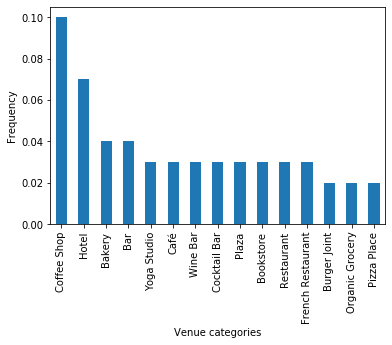

In [500]:
# Bar plot for the most common venues in Amsterdam
plot_most_common_venues(df_ams, num_top_venues)

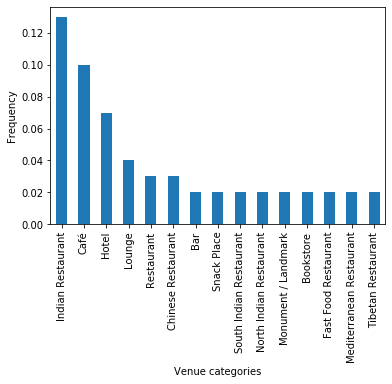

In [501]:
# Bar plot for the most common venues in Delhi
plot_most_common_venues(df_del, num_top_venues)

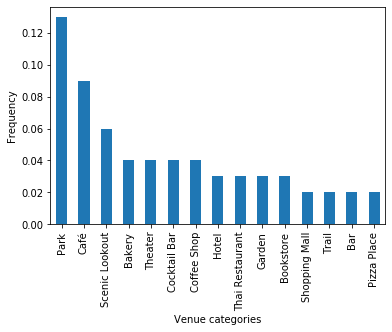

In [502]:
# Bar plot for the most common venues in Sydney
plot_most_common_venues(df_syd, num_top_venues)

#### 5. Find the 15 most common venues in the cities. 

We will sort the frequency of venues nearby in descending order and select the top 15 venues from the datasets. 

In [503]:
def most_common_venues(x, num_top_venues):
    x.drop('city', inplace = True)
    x_sort = x.sort_values(ascending = False)
    x_sort_return = x_sort[0:num_top_venues]
    return(x_sort_return.index.values[0:num_top_venues])

In [504]:
num_top_venues = 15
indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['city']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
df_grouped_sorted = pd.DataFrame(columns=columns)
df_grouped_sorted['city'] = df_grouped['city']

for ind in df_grouped.index:
    df_grouped_sorted.iloc[ind, 1:] = most_common_venues(df_grouped.iloc[ind], num_top_venues)
   
df_grouped_sorted    

,city,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue,11th Most Common Venue,12th Most Common Venue,13th Most Common Venue,14th Most Common Venue,15th Most Common Venue
0,Ahmedabad,Café,Indian Restaurant,Restaurant,Hotel,Vegetarian / Vegan Restaurant,Fast Food Restaurant,Dessert Shop,Pizza Place,Coffee Shop,Multiplex,Bakery,Sandwich Place,Tea Room,Snack Place,History Museum
1,Amsterdam,Coffee Shop,Hotel,Bakery,Bar,Yoga Studio,Café,Wine Bar,Cocktail Bar,Plaza,Bookstore,Restaurant,French Restaurant,Burger Joint,Organic Grocery,Pizza Place
2,Bangalore,Hotel,Indian Restaurant,Ice Cream Shop,Bakery,Italian Restaurant,Brewery,Lounge,Department Store,Burger Joint,Pub,Breakfast Spot,Bowling Alley,Plaza,Park,Shopping Mall
3,Berlin,Coffee Shop,Park,Bookstore,Ice Cream Shop,Café,Bakery,Wine Bar,Sandwich Place,Monument / Landmark,Gourmet Shop,Art Gallery,Falafel Restaurant,Arts & Crafts Store,Concert Hall,Garden
4,Brisbane,Park,Coffee Shop,Beer Bar,Brewery,Hotel,Farmers Market,Café,Bar,Italian Restaurant,Scenic Lookout,Art Gallery,Cocktail Bar,Brazilian Restaurant,Thai Restaurant,Concert Hall
5,Cologne,Park,Café,Coffee Shop,Italian Restaurant,Burger Joint,Bar,Hotel,Ice Cream Shop,Pedestrian Plaza,Plaza,Restaurant,Gym / Fitness Center,Cocktail Bar,German Restaurant,Scenic Lookout
6,Delhi,Indian Restaurant,Café,Hotel,Lounge,Restaurant,Chinese Restaurant,Bar,Snack Place,South Indian Restaurant,North Indian Restaurant,Monument / Landmark,Bookstore,Fast Food Restaurant,Mediterranean Restaurant,Tibetan Restaurant
7,Melbourne,Café,Coffee Shop,Park,Bar,Cocktail Bar,Ice Cream Shop,Plaza,Hotel,Boutique,Wine Bar,Gym / Fitness Center,Thai Restaurant,Japanese Restaurant,Bakery,Whisky Bar
8,Mumbai,Hotel,Indian Restaurant,Dessert Shop,Café,Pizza Place,Ice Cream Shop,Cricket Ground,Fast Food Restaurant,Scenic Lookout,Gym / Fitness Center,Diner,Deli / Bodega,Nightclub,Pub,Theater
9,Munich,Café,Plaza,Ice Cream Shop,Hotel,Gourmet Shop,Coffee Shop,Cocktail Bar,Italian Restaurant,Department Store,Beer Garden,Beach,Opera House,Surf Spot,Pastry Shop,Vietnamese Restaurant


#### 6. Apply K-mean cluster algorithm to identify the clusters.

We are giving 3 as a number of cluster and fit our pre-processed dataset to k-mean algorithm. 

In [421]:
# set number of clusters
kclusters = 3

df_grouped_clustering = df_grouped.drop('city', 1)
df_grouped_clustering

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(df_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:15] 

array([1, 0, 1, 0, 0, 2, 1, 2, 1, 2, 2, 0, 2], dtype=int32)

In [422]:
# add clustering labels
df_grouped_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

city_merged = df_city

city_merged = city_merged.join(df_grouped_sorted.set_index('city'), on='city')

city_merged.head(15) # check the last columns!

,city,latitude,longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue,11th Most Common Venue,12th Most Common Venue,13th Most Common Venue,14th Most Common Venue,15th Most Common Venue
0,Perth,-31.952712,115.860480,2,Café,Coffee Shop,Park,Bakery,Italian Restaurant,Hotel,Vietnamese Restaurant,Asian Restaurant,Ice Cream Shop,Gym,Australian Restaurant,Pizza Place,Supermarket,Theater,Stadium
1,Sydney,-33.854816,151.216454,2,Park,Café,Scenic Lookout,Coffee Shop,Theater,Cocktail Bar,Bakery,Hotel,Bookstore,Bar,Thai Restaurant,Pizza Place,Pub,Sandwich Place,Garden
2,Melbourne,-37.814218,144.963161,2,Café,Coffee Shop,Park,Bar,Cocktail Bar,Ice Cream Shop,Plaza,Hotel,Bakery,Japanese Restaurant,Monument / Landmark,Gym / Fitness Center,Whisky Bar,Bookstore,Thai Restaurant
3,Brisbane,-27.468968,153.023499,0,Coffee Shop,Park,Beer Bar,Brewery,Hotel,Café,Italian Restaurant,Bar,Farmers Market,Scenic Lookout,Trail,Cocktail Bar,Thai Restaurant,Theater,Brazilian Restaurant
4,Amsterdam,52.372760,4.893604,0,Coffee Shop,Hotel,Bar,Bakery,Cocktail Bar,French Restaurant,Plaza,Café,Yoga Studio,Bookstore,Cheese Shop,Restaurant,Breakfast Spot,Park,Canal
5,Rotterdam,51.922896,4.463173,0,Coffee Shop,Café,Bakery,Hotel,Restaurant,Bar,Park,Movie Theater,Sandwich Place,Deli / Bodega,Scenic Lookout,Museum,Market,Ice Cream Shop,French Restaurant
6,Berlin,52.517037,13.388860,0,Coffee Shop,Park,Bookstore,Ice Cream Shop,Bakery,Wine Bar,Monument / Landmark,Café,Gourmet Shop,Art Gallery,Concert Hall,Arts & Crafts Store,Breakfast Spot,Farmers Market,Hotel
7,Munich,48.137108,11.575382,2,Café,Plaza,Ice Cream Shop,Cocktail Bar,Gourmet Shop,Hotel,Coffee Shop,Department Store,Beer Garden,Italian Restaurant,Beach,Surf Spot,Pastry Shop,Church,German Restaurant
8,Cologne,50.938361,6.959974,2,Park,Café,Coffee Shop,Burger Joint,Italian Restaurant,Plaza,Bar,Hotel,Ice Cream Shop,Restaurant,Pedestrian Plaza,Scenic Lookout,Cocktail Bar,Beer Garden,Gym / Fitness Center
9,Delhi,28.651718,77.221939,1,Indian Restaurant,Café,Hotel,Lounge,Chinese Restaurant,Restaurant,Coffee Shop,Bar,Monument / Landmark,Fast Food Restaurant,Mediterranean Restaurant,Snack Place,South Indian Restaurant,Bookstore,Tibetan Restaurant


In [423]:
# create map and display same color for the cities of same cluster. 
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=3)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(city_merged['latitude'], city_merged['longitude'], city_merged['city'], city_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

### Examine cluster = 0
The most dominant venues are coffee shop, Park, hotel, brewery and bar. Apart from these venues, they have yoga studio, monument / landmark and art gallary.

In [505]:
city_merged[city_merged['Cluster Labels'] == 0]

,city,latitude,longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue,11th Most Common Venue,12th Most Common Venue,13th Most Common Venue,14th Most Common Venue,15th Most Common Venue
3,Brisbane,-27.468968,153.023499,0,Coffee Shop,Park,Beer Bar,Brewery,Hotel,Café,Italian Restaurant,Bar,Farmers Market,Scenic Lookout,Trail,Cocktail Bar,Thai Restaurant,Theater,Brazilian Restaurant
4,Amsterdam,52.372760,4.893604,0,Coffee Shop,Hotel,Bar,Bakery,Cocktail Bar,French Restaurant,Plaza,Café,Yoga Studio,Bookstore,Cheese Shop,Restaurant,Breakfast Spot,Park,Canal
5,Rotterdam,51.922896,4.463173,0,Coffee Shop,Café,Bakery,Hotel,Restaurant,Bar,Park,Movie Theater,Sandwich Place,Deli / Bodega,Scenic Lookout,Museum,Market,Ice Cream Shop,French Restaurant
6,Berlin,52.517037,13.388860,0,Coffee Shop,Park,Bookstore,Ice Cream Shop,Bakery,Wine Bar,Monument / Landmark,Café,Gourmet Shop,Art Gallery,Concert Hall,Arts & Crafts Store,Breakfast Spot,Farmers Market,Hotel


### Examine cluster = 1

The most dominant venues are Indian restaurant, hotel and cafe. However, there no park or scenic lookout in the 8 km range. It is possible that park and scenic lookout can be at the outskirt of city or there are none. This can be an opportunity for government to look into details and improve the city lifestyle by taking actions. 

In [399]:
city_merged[city_merged['Cluster Labels'] == 1]

,city,latitude,longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue,11th Most Common Venue,12th Most Common Venue,13th Most Common Venue,14th Most Common Venue,15th Most Common Venue
9,Delhi,28.651718,77.221939,1,Indian Restaurant,Café,Hotel,Lounge,Chinese Restaurant,Restaurant,Fast Food Restaurant,Snack Place,Monument / Landmark,Bookstore,Tibetan Restaurant,Bar,BBQ Joint,South Indian Restaurant,Mediterranean Restaurant
10,Mumbai,18.938771,72.835335,1,Indian Restaurant,Hotel,Dessert Shop,Café,Scenic Lookout,Fast Food Restaurant,Pizza Place,Ice Cream Shop,Cricket Ground,Theater,Diner,Deli / Bodega,Pub,Coffee Shop,Lounge
11,Bangalore,12.979120,77.591300,1,Hotel,Ice Cream Shop,Indian Restaurant,Bakery,Pub,Brewery,Department Store,Lounge,Burger Joint,Italian Restaurant,Breakfast Spot,Bowling Alley,Gym / Fitness Center,Shopping Mall,Park
12,Ahmedabad,23.021624,72.579707,1,Café,Indian Restaurant,Restaurant,Hotel,Vegetarian / Vegan Restaurant,Dessert Shop,Fast Food Restaurant,Pizza Place,Coffee Shop,Multiplex,Bakery,Sandwich Place,Tea Room,Snack Place,History Museum


### Examine cluster = 2

The most dominant venues in this clusters are cafe, park/ sceninc lookout.

In [400]:
city_merged[city_merged['Cluster Labels'] == 2]

,city,latitude,longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue,11th Most Common Venue,12th Most Common Venue,13th Most Common Venue,14th Most Common Venue,15th Most Common Venue
0,Perth,-31.952712,115.860480,2,Café,Coffee Shop,Park,Bakery,Asian Restaurant,Italian Restaurant,Hotel,Ice Cream Shop,Vietnamese Restaurant,Gym,Cocktail Bar,Stadium,Supermarket,Theater,Pizza Place
1,Sydney,-33.854816,151.216454,2,Park,Café,Scenic Lookout,Coffee Shop,Theater,Cocktail Bar,Bakery,Garden,Bar,Hotel,Bookstore,Ice Cream Shop,Thai Restaurant,Pub,Shopping Mall
2,Melbourne,-37.814218,144.963161,2,Café,Coffee Shop,Park,Bar,Cocktail Bar,Plaza,Ice Cream Shop,Thai Restaurant,Bakery,Gym / Fitness Center,Monument / Landmark,Hotel,Bookstore,Whisky Bar,Wine Bar
7,Munich,48.137108,11.575382,2,Café,Plaza,Ice Cream Shop,Cocktail Bar,Gourmet Shop,Coffee Shop,Department Store,Beach,Italian Restaurant,Beer Garden,Hotel,Vietnamese Restaurant,Opera House,Pastry Shop,German Restaurant
8,Cologne,50.938361,6.959974,2,Park,Café,Coffee Shop,Italian Restaurant,Plaza,Burger Joint,Bar,Hotel,Ice Cream Shop,French Restaurant,Pedestrian Plaza,Restaurant,Kebab Restaurant,Middle Eastern Restaurant,Cocktail Bar


## Conclusion
The venues are selected within the radius of 8 km from the city center. However, some of the cities can be bigger than this radius. Hence, these results indicate that if a person is living close to the city center, (s)he can will have the above mentioned venue in the radius of 8 km. 

Restaurnats are all over the place, so one would have a varity of food to explore. If we exmine the cities in India, the parks and sceninc lookout are rarely found. This can be an opportunity for the government to improve the city lifestyle by employing more parks in the cities. 

On examining the cluster 0 which comprises the 3 cities from Europe (Amsterdam, Rotterdam and Berlin) and 1 city from Australia (Brisbane), we fuound that the most common venues are coffee shop, park, hotel, brewery and bar. Apart from these venue, they also have yoga studio and monument/landmarks.

On examining the cluster 2 which comprises of 3 cities from Australia and 2 cities from Europe. The most common venue are cafe, coffee shop, park. 
